In [2]:
from pathlib import Path
path_to_data_notebook = Path.cwd().parent.parent / "Data" / "Data_v2.ipynb"
print(path_to_data_notebook)
%run {path_to_data_notebook}

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import datetime 
import time
from sklearn.model_selection import train_test_split

/home/pc/moje/python_projects/adsorbents_isotherms/Data/Data_v2.ipynb


2025-03-18 18:00:16.042070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742317216.061409  929670 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742317216.067070  929670 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 18:00:16.086795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
size = 35
X,y,info,oryginal = get_data(size, data_type_choose='Micropore_volume[cm3/g]' ,x_range_to_cut=0.005,flat=True, three_variable_at_once=True);
y_all_nested = [] # for showing names of specific smples at the end during model evaluation
for i in range(len(y)):
    y_all_nested.append([y[i],info[i]])

X_train, X_test, y_train_nested, y_test_nested, = train_test_split(X, y_all_nested, test_size=0.02, random_state=42) #random_state=42
y_train = [item[0] for item in y_train_nested]
y_train = np.array(y_train).astype(float)
y_test = [item[0] for item in y_test_nested]
y_test = np.array(y_test).astype(float)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(X_train[0])
print(len(X_train))
print(len(X_test))

/home/pc/moje/python_projects/adsorbents_isotherms/Data/all_data.csv
<class 'pandas.core.frame.DataFrame'>
Index: 980 entries, 0 to 1010
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Article_name                    980 non-null    object 
 1   Figure_number                   980 non-null    object 
 2   Sample_name                     980 non-null    object 
 3   Total_surface_area[m2/g]        897 non-null    float64
 4   Total_pore_volume[cm3/g]        749 non-null    float64
 5   Micropore_volume[cm3/g]         719 non-null    float64
 6   Mesopore_volume[cm3/g]          21 non-null     float64
 7   Average_pore_diameter[nm]       121 non-null    float64
 8   Impregnation_ratio[agent/char]  20 non-null     float64
 9   Activation_type                 33 non-null     object 
 10  Burn_off[%]                     75 non-null     float64
 11  Carbonization_time[h]           

In [7]:
# print(y)

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
def calculate_time(transcription_time):
    timedelta_obj = datetime.timedelta(seconds=int(transcription_time))
    return str(timedelta_obj)

In [11]:
epochs_number = 500

model = tf.keras.Sequential([ 
    tf.keras.layers.Dense(size, activation='relu'), 
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(3)                      
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics=['mae', 'mse']
model.compile(optimizer=optimizer, loss='mae', metrics=metrics)



# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# history  =  model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=2)
start = time.time()
history  =  model.fit(X_train, y_train, epochs=epochs_number, batch_size=32, validation_split=0.1, verbose=2)
end = time.time()
transcription_time = calculate_time(round((end - start),2))
print(f"Model training time: "+transcription_time)
model.summary()
results = model.evaluate(X_test, y_test, verbose=0)
print("Metrics:",results)
for index, metric in enumerate(metrics):
    print(f"{metric} = {results[index+1]}")




Epoch 1/500


I0000 00:00:1742317284.495395  929670 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9438 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:09:00.0, compute capability: 7.5
I0000 00:00:1742317285.511461  930635 service.cc:148] XLA service 0x775f8400bd20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742317285.511488  930635 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-03-18 18:01:25.545759: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742317285.670281  930635 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742317286.291010  930635 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 - 3s - 149ms/step - loss: 339.2834 - mae: 339.2834 - mse: 472148.2500 - val_loss: 325.6840 - val_mae: 325.6840 - val_mse: 461667.0312
Epoch 2/500
18/18 - 0s - 5ms/step - loss: 337.7053 - mae: 337.7053 - mse: 469107.9062 - val_loss: 322.7803 - val_mae: 322.7803 - val_mse: 455357.1875
Epoch 3/500
18/18 - 0s - 5ms/step - loss: 331.4010 - mae: 331.4010 - mse: 455607.0938 - val_loss: 310.1232 - val_mae: 310.1232 - val_mse: 427928.7500
Epoch 4/500
18/18 - 0s - 5ms/step - loss: 309.8580 - mae: 309.8580 - mse: 405350.2812 - val_loss: 275.9800 - val_mae: 275.9800 - val_mse: 342240.2188
Epoch 5/500
18/18 - 0s - 5ms/step - loss: 258.4058 - mae: 258.4058 - mse: 285334.3438 - val_loss: 204.8110 - val_mae: 204.8110 - val_mse: 181159.5625
Epoch 6/500
18/18 - 0s - 5ms/step - loss: 177.4164 - mae: 177.4164 - mse: 131574.2812 - val_loss: 126.3160 - val_mae: 126.3160 - val_mse: 72041.1094
Epoch 7/500
18/18 - 0s - 5ms/step - loss: 126.3617 - mae: 126.3617 - mse: 73684.1719 - val_loss: 120.7379 - val

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 35)             │         2,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 140)            │         5,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         7,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,186 (172.61 KB)

 Trainable params: 14,728 (57.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,458 (115.07 KB)

Metrics: [13.935089111328125, 13.935089111328125, 900.0507202148438]
mae = 13.935089111328125
mse = 900.0507202148438


Model training time without gpu, epoch = 1000 : 0:01:10

Metrics: [13.935089111328125, 13.935089111328125, 900.0507202148438]
mae = 13.935089111328125
mse = 900.0507202148438


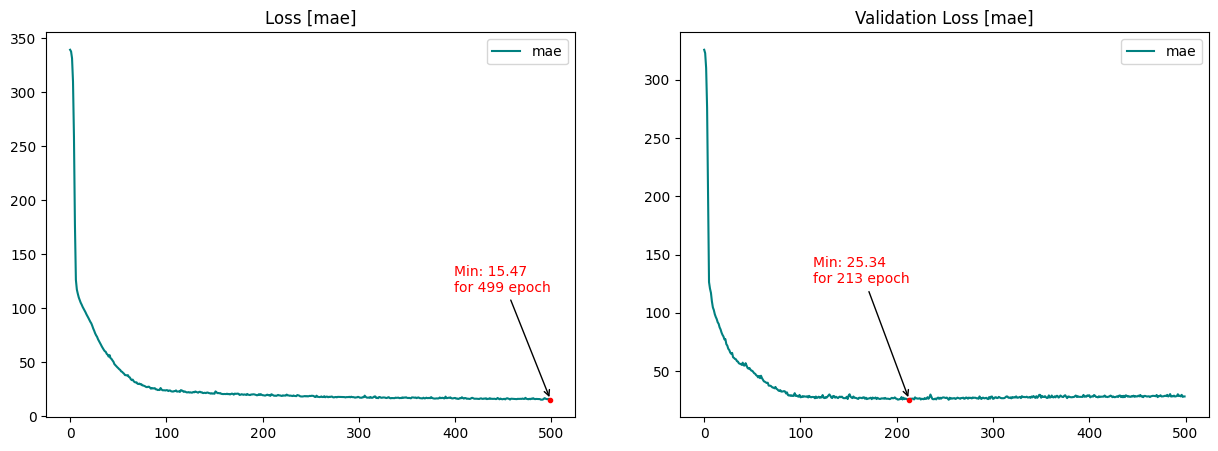

In [12]:
results = model.evaluate(X_test, y_test, verbose=0)
print("Metrics:",results)
for index, metric in enumerate(metrics):
    print(f"{metric} = {results[index+1]}")

from matplotlib import pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

min_loss_idx = history.history['loss'].index(min(history.history['loss']))
min_loss = min(history.history['loss'])# Get the lowest  value
ax[0].plot(history.history['loss'], color='teal', label='mae')
# ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss [mae]')
ax[0].legend()
ax[0].annotate(f'Min: {min_loss:.2f} \nfor {min_loss_idx} epoch', 
               xy=(min_loss_idx, min_loss), 
               xytext=(min_loss_idx - 100, min_loss + 100),  # Adjust text position
               arrowprops=dict(facecolor='red', arrowstyle="->"),
               color='red')
ax[0].plot(min_loss_idx, min_loss, 'ro',markersize=3)# Plot a dot at the minimum point


min_val_loss_idx = history.history['val_loss'].index(min(history.history['val_loss']))# Find the index of the minimum 
min_val_loss = min(history.history['val_loss'])# Get the lowest  value
ax[1].plot(history.history['val_loss'], color='teal', label='mae')
# ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Validation Loss [mae]')
ax[1].legend()
# Annotate the lowest point on the validation loss curve
ax[1].annotate(f'Min: {min_val_loss:.2f} \nfor {min_val_loss_idx} epoch', 
               xy=(min_val_loss_idx, min_val_loss), 
               xytext=(min_val_loss_idx - 100, min_val_loss + 100),  # Adjust text position
               arrowprops=dict(facecolor='red', arrowstyle="->"),
               color='red')
ax[1].plot(min_val_loss_idx, min_val_loss, 'ro', markersize=3)# Plot a dot at the minimum point

# ax[2].plot(history.history['val_mse'], color='teal', label='regress loss')
# # ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
# ax[2].title.set_text('Validation mse')
# ax[2].legend()

plt.show()

In [31]:
predictions = model.predict(X_test, verbose=0)
print(f'{predictions[0][0]:.2f} {predictions[0][1]:.2f} {predictions[0][2]:.2f}')
print(f'{y_test[0][0]:.2f} {y_test[0][1]:.2f} {y_test[0][2]:.2f}')
y_test_nested[0][1]


1419.58 0.66 0.65
1343.00 0.93 0.70


['Data150', '10stC', '4', 'I_II']

In [34]:
error_threshold = 30
max_error_threshold = 30
predictions = model.predict(X_test, verbose=0)
list_below =[]
list_above=[]
errors = []
predictions = predictions[:,0]
y_test = y_test[:,0]
for i in range(len(predictions)):
    errors.append(abs(predictions[i] - y_test[i]))
    # print(f"{i} {predictions[i]}  ------   {y_valid[i]}           blad: {abs(predictions[i] - y_valid[i])}")
    # if(abs(predictions[i] - y_test[i]) > max_error_threshold):
    #     print(f" przewidywana --> {predictions[i]}     {y_test[i]} <-- rzeczyswista     blad: {abs(predictions[i] - y_test[i])}  {y_test_nested[i][1]}")
        
    if(error_threshold<=abs(predictions[i] - y_test[i])):
        list_above.append(i)
    else: list_below.append(i)

print("\nALL:")
for i in range(len(predictions)):
    print(f" przewidywana --> {predictions[i]}     {y_test[i]} <-- rzeczyswista     blad: {abs(predictions[i] - y_test[i])}  {y_test_nested[i][1]}")

print(f"max error: {max(errors)}  dla {y_test_nested[errors.index(max(errors))][1]} " )
print(f"for error thteshold[{error_threshold}] - {round((len(list_below)/len(predictions))*100,2)}%     {len(list_below)} izotermy na {len(predictions)}")

[1419.577    939.6334  1960.9395  2201.4092   830.4367   112.03622
 3417.825    503.94168  601.08575  551.7029  1034.4565  1627.3964
  742.8846   407.08136]

ALL:
 przewidywana --> 1419.5770263671875     1343.0 <-- rzeczyswista     blad: 76.5770263671875  ['Data150', '10stC', '4', 'I_II']
 przewidywana --> 939.6334228515625     910.0 <-- rzeczyswista     blad: 29.6334228515625  ['Data75', '400stC', '4_1', 'I_IV']
 przewidywana --> 1960.939453125     1951.0 <-- rzeczyswista     blad: 9.939453125  ['Data74', 'ACK-2-8', '4', 'I']
 przewidywana --> 2201.4091796875     2227.0 <-- rzeczyswista     blad: 25.5908203125  ['Data69', 'D3065013', '1', 'I']
 przewidywana --> 830.4367065429688     762.0 <-- rzeczyswista     blad: 68.43670654296875  ['Data43', 'F1-8-77', '6', 'I']
 przewidywana --> 112.03621673583984     26.0 <-- rzeczyswista     blad: 86.03621673583984  ['Data125', 'bengkirai_wood_400', '3', 'I_II']
 przewidywana --> 3417.824951171875     3441.0 <-- rzeczyswista     blad: 23.1750488

In [45]:
#model.save("saved_models/model_s35_500_mae3400_maxerr-121_warstwy-35-160-50.keras")


In [46]:
from tensorflow.keras.models import load_model
model_name = 'saved_models/model_s35_500_mae34_maxerr-121_warstwy-35-160-50.keras'
modelos = load_model(model_name)
predictions = modelos.predict(X_test, verbose=0)
print(f"len {len(X_test)}")
error_threshold = 30
max_error_threshold = 30
list_below =[]
list_above=[]
errors = []
for i in range(len(predictions)):
    errors.append(abs(predictions[i] - y_test[i]))
    # print(f"{i} {predictions[i]}  ------   {y_valid[i]}           blad: {abs(predictions[i] - y_valid[i])}")
    # if(abs(predictions[i] - y_test[i]) > max_error_threshold):
    #     print(f" przewidywana --> {predictions[i]}     {y_test[i]} <-- rzeczyswista     blad: {abs(predictions[i] - y_test[i])}  {y_test_nested[i][1]}")
        
    if(error_threshold<=abs(predictions[i] - y_test[i])):
        list_above.append(i)
    else: list_below.append(i)
print("\nALL:")
for i in range(len(predictions)):
    print(f" przewidywana --> {predictions[i]}     {y_test[i]} <-- rzeczyswista     blad: {abs(predictions[i] - y_test[i])}  {y_test_nested[i][1]}")
        


print(f"max error: {max(errors)}  dla {y_test_nested[errors.index(max(errors))][1]} " )
print(f"for error thteshold[{error_threshold}] - {round((len(list_below)/len(predictions))*100,2)}%     {len(list_below)} izotermy na {len(predictions)}")

len 18

ALL:
 przewidywana --> [971.2737]     1041.9 <-- rzeczyswista     blad: [70.62631836]  ['Data58', '850-45m', '5_4', 'II']
 przewidywana --> [395.97638]     378.0 <-- rzeczyswista     blad: [17.97637939]  ['Data115', 'CAC1900', '1', 'I']
 przewidywana --> [742.24585]     770.1 <-- rzeczyswista     blad: [27.85415039]  ['Data58', '800-1h', '5_3', 'II']
 przewidywana --> [1362.1091]     1343.0 <-- rzeczyswista     blad: [19.10913086]  ['Data150', '10stC', '4', 'I_II']
 przewidywana --> [590.9509]     659.0 <-- rzeczyswista     blad: [68.04907227]  ['Data7', 'RK-600', '3', 'I']
 przewidywana --> [776.3707]     817.2 <-- rzeczyswista     blad: [40.82927246]  ['Data58', '800-1h15m', '5_3', 'II']
 przewidywana --> [1479.6089]     1387.0 <-- rzeczyswista     blad: [92.60888672]  ['Data65', 'R2-500', '2_2', 'I_IV']
 przewidywana --> [2005.0792]     2064.0 <-- rzeczyswista     blad: [58.92077637]  ['Data59', 'CMS500', '2', 'I_II']
 przewidywana --> [457.05875]     448.0 <-- rzeczyswista 

In [ ]:
#  przewidywana --> [553.189]     249.0 <-- rzeczyswista     blad: [304.18903]  ['Data125', 'coconut_shells_6h', '7']
#  przewidywana --> [1967.7969]     1616.22 <-- rzeczyswista     blad: [351.5769]  ['Data153', 'GC-C04', '4']
#  przewidywana --> [1556.715]     1193.2 <-- rzeczyswista     blad: [363.515]  ['Data54', 'CZ0.65', '3']
#  przewidywana --> [1296.133]     938.0 <-- rzeczyswista     blad: [358.13306]  ['Data15', '3', '1']
#  przewidywana --> [732.7655]     1188.0 <-- rzeczyswista     blad: [455.2345]  ['Data156', 'MCAC-2-1', '4']
#  przewidywana --> [573.38586]     976.0 <-- rzeczyswista     blad: [402.61414]  ['Data47', 'ACF30M-HNO3', '3']
#  przewidywana --> [350.85513]     823.0 <-- rzeczyswista     blad: [472.14487]  ['Data86', 'ACZ3', '2']
# max error: [472.14487]  dla ['Data86', 'ACZ3', '2'] 
# for error thteshold[50] - 57.8%     100 izotermy na 173